# 2025 Fall AI course Connect 4 Competition

In [1]:
# %pip install matplotlib numpy scipy

from environment import truly_dynamic_environment, replay, visualize
import numpy as np

Define agent functions. One example used a simple function and the second uses a class which should be used for model-based agents.

In [2]:
import math
import random
import time
from environment import HelperFunctions  

class AlphaBetaAgent:
    def __init__(self, depth=5, time_limit=4.8):
        self.depth = depth
        self.time_limit = time_limit
        self.start_time = None
        self.player = None

    def act(self, board, player, **kwargs):
        self.start_time = time.time()
        self.player = player

        legal_moves = HelperFunctions.get_valid_moves(board)
        best_move = random.choice(legal_moves)
        best_score = -math.inf

        for move in legal_moves:
            if self._timeout():
                break

            next_board = HelperFunctions.place(move, board.copy(), player)
            score = self.min_value(next_board, self.depth - 1, -math.inf, math.inf)

            if score > best_score:
                best_score = score
                best_move = move

        return best_move

    def max_value(self, board, depth, alpha, beta):
        if self._terminal_or_timeout(board, depth):
            return self.evaluate(board)

        value = -math.inf
        for move in HelperFunctions.get_valid_moves(board):
            next_board = HelperFunctions.place(move, board.copy(), self.player)
            value = max(value, self.min_value(next_board, depth - 1, alpha, beta))

            if value >= beta:
                return value
            alpha = max(alpha, value)

            if self._timeout():
                break

        return value

    def min_value(self, board, depth, alpha, beta):
        opp = -self.player

        if self._terminal_or_timeout(board, depth):
            return self.evaluate(board)

        value = math.inf
        for move in HelperFunctions.get_valid_moves(board):
            next_board = HelperFunctions.place(move, board.copy(), opp)
            value = min(value, self.max_value(next_board, depth - 1, alpha, beta))

            if value <= alpha:
                return value
            beta = min(beta, value)

            if self._timeout():
                break

        return value

    def evaluate(self, board):
        winner = HelperFunctions.check_win(board)

        if winner == self.player:
            return 10_000
        elif winner == -self.player:
            return -10_000
        elif winner == 0:
            return 0  # draw

        score = 0
        rows = len(board)
        cols = len(board[0])

        # center column weighting
        center_col = cols // 2
        center_count = sum(1 for r in range(rows) if board[r][center_col] == self.player)
        score += center_count * 4

        # score potential threats
        score += self._score_windows(board, self.player)
        score -= 1.1 * self._score_windows(board, -self.player)

        return score

    def _score_windows(self, board, player):
        rows = len(board)
        cols = len(board[0])
        score = 0

        def score_window(w):
            p = w.count(player)
            z = w.count(0)
            if p == 4: return 1000
            if p == 3 and z == 1: return 50
            if p == 2 and z == 2: return 10
            return 0

        # horizontal
        for r in range(rows):
            for c in range(cols - 3):
                w = [board[r][c+i] for i in range(4)]
                score += score_window(w)

        # vertical
        for c in range(cols):
            for r in range(rows - 3):
                w = [board[r+i][c] for i in range(4)]
                score += score_window(w)

        # diagonal /
        for r in range(rows - 3):
            for c in range(cols - 3):
                w = [board[r+i][c+i] for i in range(4)]
                score += score_window(w)

        # diagonal \
        for r in range(3, rows):
            for c in range(cols - 3):
                w = [board[r-i][c+i] for i in range(4)]
                score += score_window(w)

        return score

    def _timeout(self):
        return (time.time() - self.start_time) >= self.time_limit

    def _terminal_or_timeout(self, board, depth):
        return depth == 0 or HelperFunctions.check_win(board) is not None or self._timeout()


In [3]:
import numpy as np
import random
from timeit import default_timer as timer
from typing import Optional, Tuple, Dict, List

# constants
ROWS = 6
COLS = 7
EMPTY = 0
PLAYER_1 = 1
PLAYER_2 = -1
WIN_SCORE = 1_000_000
DRAW_SCORE = 0
EXACT = 0
LOWERBOUND = 1
UPPERBOUND = 2

# Position value map
POSITION_VALUE = np.array([
    [3, 4, 5, 7, 5, 4, 3],
    [4, 6, 8, 10, 8, 6, 4],
    [5, 8, 11, 13, 11, 8, 5],
    [5, 8, 11, 13, 11, 8, 5],
    [4, 6, 8, 10, 8, 6, 4],
    [3, 4, 5, 7, 5, 4, 3]
], dtype=np.int32)

# Zobrist hashing implementation
class ZobristHash:
    def __init__(self, rows: int = ROWS, cols: int = COLS, seed: int = 42):
        random.seed(seed)
        self.keys = np.zeros((rows, cols, 2), dtype=np.uint64)
        for r in range(rows):
            for c in range(cols):
                for p in range(2):
                    self.keys[r, c, p] = random.getrandbits(64)
        self.rows = rows
        self.cols = cols

    def compute_hash(self, board: np.ndarray) -> int:
        h = 0
        for r in range(self.rows):
            for c in range(self.cols):
                piece = board[r, c]
                if piece == PLAYER_1:
                    h ^= int(self.keys[r, c, 0])
                elif piece == PLAYER_2:
                    h ^= int(self.keys[r, c, 1])
        return h

    def update_hash(self, current_hash: int, row: int, col: int, player: int) -> int:
        player_idx = 0 if player == PLAYER_1 else 1
        return current_hash ^ int(self.keys[row, col, player_idx])

# Transposition table (simple dictionary-based)
class TranspositionTable:
    def __init__(self, max_size: int = 2_000_000):
        self.table: Dict[int, Tuple[int, int, int, Optional[int]]] = {}
        self.max_size = max_size
        self.hits = 0
        self.stores = 0

    def lookup(self, hash_key: int, depth: int, alpha: int, beta: int) -> Optional[Tuple[int, Optional[int]]]:
        if hash_key not in self.table:
            return None
        stored_depth, stored_score, flag, best_move = self.table[hash_key]
        if stored_depth < depth:
            return None
        self.hits += 1
        if flag == EXACT:
            return (stored_score, best_move)
        elif flag == LOWERBOUND and stored_score >= beta:
            return (stored_score, best_move)
        elif flag == UPPERBOUND and stored_score <= alpha:
            return (stored_score, best_move)
        return None

    def get_best_move(self, hash_key: int) -> Optional[int]:
        if hash_key in self.table:
            return self.table[hash_key][3]
        return None

    def store(self, hash_key: int, depth: int, score: int, flag: int, best_move: Optional[int]):
        self.table[hash_key] = (depth, score, flag, best_move)
        self.stores += 1

    def clear(self):
        self.table.clear()
        self.hits = 0
        self.stores = 0

# Classic solver based on agent.py but renamed to avoid collisions
class InterativeAgent:
    def __init__(self):
        self.zobrist = ZobristHash()
        self.tt = TranspositionTable()
        self.nodes_searched = 0
        self.max_time = 15.0
        self.start_time = 0
        self.killer_moves = {}
        self.timeout_occurred = False

    def get_valid_moves(self, board: np.ndarray) -> List[int]:
        return [c for c in range(COLS) if board[0, c] == EMPTY]

    def make_move(self, board: np.ndarray, col: int, player: int) -> Tuple[np.ndarray, int]:
        new_board = board.copy()
        for row in range(ROWS - 1, -1, -1):
            if new_board[row, col] == EMPTY:
                new_board[row, col] = player
                return new_board, row
        raise ValueError(f"Column {col} is full!")

    def _check_win_fast(self, board: np.ndarray, row: int, col: int, player: int) -> bool:
        directions = [(0, 1), (1, 0), (1, 1), (1, -1)]
        for dr, dc in directions:
            count = 1
            r, c = row + dr, col + dc
            while 0 <= r < ROWS and 0 <= c < COLS and board[r, c] == player:
                count += 1
                r += dr
                c += dc
            r, c = row - dr, col - dc
            while 0 <= r < ROWS and 0 <= c < COLS and board[r, c] == player:
                count += 1
                r -= dr
                c -= dc
            if count >= 4:
                return True
        return False

    def get_ordered_moves(self, board: np.ndarray, player: int, hash_key: int, depth: int) -> List[int]:
        valid_moves = self.get_valid_moves(board)
        if not valid_moves:
            return []
        scored_moves = []
        winning_move = None
        blocking_move = None
        for col in valid_moves:
            new_board, row = self.make_move(board, col, player)
            if self._check_win_fast(new_board, row, col, player):
                winning_move = col
                break
            opp_board, opp_row = self.make_move(board, col, -player)
            if self._check_win_fast(opp_board, opp_row, col, -player):
                blocking_move = col
                score = 10000
            else:
                score = (COLS // 2 - abs(col - COLS // 2)) * 10
            scored_moves.append((score, col))
        if winning_move is not None:
            return [winning_move]
        scored_moves.sort(reverse=True)
        ordered = [m[1] for m in scored_moves]
        tt_move = self.tt.get_best_move(hash_key)
        if tt_move is not None and tt_move in ordered:
            ordered.remove(tt_move)
            ordered.insert(0, tt_move)
        if depth in self.killer_moves:
            for killer in self.killer_moves[depth]:
                if killer in ordered and killer != ordered[0]:
                    ordered.remove(killer)
                    ordered.insert(min(2, len(ordered)), killer)
        return ordered

    def update_killer_move(self, depth: int, move: int):
        if depth not in self.killer_moves:
            self.killer_moves[depth] = []
        killers = self.killer_moves[depth]
        if move not in killers:
            killers.insert(0, move)
            if len(killers) > 2:
                killers.pop()

    def evaluate(self, board: np.ndarray, player: int) -> int:
        score = 0
        opponent = -player
        center_col = COLS // 2
        center_count = 0
        opp_center_count = 0
        for r in range(ROWS):
            if board[r, center_col] == player:
                center_count += 1
            elif board[r, center_col] == opponent:
                opp_center_count += 1
        score += (center_count - opp_center_count) * 30
        for r in range(ROWS):
            for c in range(COLS):
                if board[r, c] == player:
                    score += POSITION_VALUE[r, c]
                elif board[r, c] == opponent:
                    score -= POSITION_VALUE[r, c]
        score += self._fast_threat_count(board, player) * 50
        score -= self._fast_threat_count(board, opponent) * 60
        return score

    def _fast_threat_count(self, board: np.ndarray, player: int) -> int:
        count = 0
        for r in range(ROWS):
            for c in range(COLS - 3):
                p_count = 0
                empty = 0
                for i in range(4):
                    cell = board[r, c + i]
                    if cell == player:
                        p_count += 1
                    elif cell == EMPTY:
                        empty += 1
                    else:
                        break
                else:
                    if p_count == 3 and empty == 1:
                        count += 2
                    elif p_count == 2 and empty == 2:
                        count += 1
        for r in range(ROWS - 3):
            for c in range(COLS):
                p_count = 0
                empty = 0
                for i in range(4):
                    cell = board[r + i, c]
                    if cell == player:
                        p_count += 1
                    elif cell == EMPTY:
                        empty += 1
                    else:
                        break
                else:
                    if p_count == 3 and empty == 1:
                        count += 2
                    elif p_count == 2 and empty == 2:
                        count += 1
        for r in range(ROWS - 3):
            for c in range(COLS - 3):
                p_count = 0
                empty = 0
                for i in range(4):
                    cell = board[r + i, c + i]
                    if cell == player:
                        p_count += 1
                    elif cell == EMPTY:
                        empty += 1
                    else:
                        break
                else:
                    if p_count == 3 and empty == 1:
                        count += 2
                    elif p_count == 2 and empty == 2:
                        count += 1
        for r in range(3, ROWS):
            for c in range(COLS - 3):
                p_count = 0
                empty = 0
                for i in range(4):
                    cell = board[r - i, c + i]
                    if cell == player:
                        p_count += 1
                    elif cell == EMPTY:
                        empty += 1
                    else:
                        break
                else:
                    if p_count == 3 and empty == 1:
                        count += 2
                    elif p_count == 2 and empty == 2:
                        count += 1
        return count

    def negamax(self, board: np.ndarray, depth: int, alpha: int, beta: int, player: int, hash_key: int) -> Tuple[int, Optional[int]]:
        self.nodes_searched += 1
        alpha_orig = alpha
        if timer() - self.start_time > self.max_time:
            self.timeout_occurred = True
            return 0, None
        tt_result = self.tt.lookup(hash_key, depth, alpha, beta)
        if tt_result is not None:
            return tt_result
        # Terminal check - fast check for winner/draw
        # Use win/window checking similar to other code (simple full board check)
        is_term = False
        winner_val = None
        # Quick board termination check (reuse function from above if available)
        # We'll implement a compact winner check here:
        def check_winner_local(bd: np.ndarray):
            for r in range(ROWS):
                for c in range(COLS - 3):
                    w = bd[r, c:c+4]
                    if np.all(w == PLAYER_1):
                        return PLAYER_1
                    if np.all(w == PLAYER_2):
                        return PLAYER_2
            for r in range(ROWS - 3):
                for c in range(COLS):
                    w = bd[r:r+4, c]
                    if np.all(w == PLAYER_1):
                        return PLAYER_1
                    if np.all(w == PLAYER_2):
                        return PLAYER_2
            for r in range(ROWS - 3):
                for c in range(COLS - 3):
                    if all(bd[r+i, c+i] == PLAYER_1 for i in range(4)):
                        return PLAYER_1
                    if all(bd[r+i, c+i] == PLAYER_2 for i in range(4)):
                        return PLAYER_2
            for r in range(3, ROWS):
                for c in range(COLS - 3):
                    if all(bd[r-i, c+i] == PLAYER_1 for i in range(4)):
                        return PLAYER_1
                    if all(bd[r-i, c+i] == PLAYER_2 for i in range(4)):
                        return PLAYER_2
            return None
        w = check_winner_local(board)
        if w is not None:
            if w == player:
                return WIN_SCORE - (42 - depth), None
            else:
                return -WIN_SCORE + (42 - depth), None
        if not self.get_valid_moves(board):
            return DRAW_SCORE, None
        if depth == 0:
            return self.evaluate(board, player), None
        moves = self.get_ordered_moves(board, player, hash_key, depth)
        if not moves:
            return DRAW_SCORE, None
        best_score = -WIN_SCORE - 1
        best_move = moves[0]
        for col in moves:
            new_board, row = self.make_move(board, col, player)
            new_hash = self.zobrist.update_hash(hash_key, row, col, player)
            score, _ = self.negamax(new_board, depth - 1, -beta, -alpha, -player, new_hash)
            score = -score
            if score > best_score:
                best_score = score
                best_move = col
            alpha = max(alpha, score)
            if alpha >= beta:
                self.update_killer_move(depth, col)
                break
        if best_score <= alpha_orig:
            flag = UPPERBOUND
        elif best_score >= beta:
            flag = LOWERBOUND
        else:
            flag = EXACT
        self.tt.store(hash_key, depth, best_score, flag, best_move)
        return best_score, best_move

    def iterative_deepening(self, board: np.ndarray, player: int, max_depth: int = 42, time_limit: float = None) -> int:
        if time_limit is not None:
            self.max_time = time_limit
        self.start_time = timer()
        self.nodes_searched = 0
        hash_key = self.zobrist.compute_hash(board)
        valid_moves = self.get_valid_moves(board)
        if len(valid_moves) == 1:
            return valid_moves[0]
        for col in valid_moves:
            new_board, row = self.make_move(board, col, player)
            if self._check_win_fast(new_board, row, col, player):
                return col
        blocking_moves = []
        for col in valid_moves:
            opp_board, opp_row = self.make_move(board, col, -player)
            if self._check_win_fast(opp_board, opp_row, col, -player):
                blocking_moves.append(col)
        if len(blocking_moves) >= 2:
            return blocking_moves[0]
        elif len(blocking_moves) == 1:
            return blocking_moves[0]
        best_move = None
        best_score = None
        for depth in range(1, max_depth + 1):
            elapsed = timer() - self.start_time
            if elapsed > self.max_time * 0.9:
                break
            self.timeout_occurred = False
            score, move = self.negamax(board, depth, -WIN_SCORE - 1, WIN_SCORE + 1, player, hash_key)
            if move is not None and not self.timeout_occurred:
                best_move = move
                best_score = score
                if score >= WIN_SCORE - 100:
                    break
        if best_move is None:
            best_move = valid_moves[len(valid_moves) // 2]
        return best_move

# Global instance and wrapper for the classic solver
_solver_classic = None

def craig_agent(board: np.ndarray, player: int, **kwargs) -> int:
    global _solver_classic
    if _solver_classic is None:
        _solver_classic = InterativeAgent()
    # time management
    pieces_on_board = np.sum(board != EMPTY)
    if pieces_on_board < 6:
        time_limit = 10
    elif pieces_on_board < 14:
        time_limit = 20
    elif pieces_on_board < 28:
        time_limit = 30
    else:
        time_limit = 40
    move = _solver_classic.iterative_deepening(board, player, max_depth=42, time_limit=time_limit)
    return move

print("Notebook agent loaded: craig_agent()")


Notebook agent loaded: craig_agent()


Create an instance of the class-based agent and create the configuration list for the environment.

In [21]:
AlphaBetaAgentInstance = AlphaBetaAgent(depth=6, time_limit=100000000000000)
players = [
    {
        "algo": craig_agent,
        "name": "Craig",
        "player": +1,
        "args": {}
    },
    {
        "algo": AlphaBetaAgentInstance.act,
        "name": "Travis",
        "player": -1,
        "args": {}
    }
]

Run the game

Craig took a total of 248.648 seconds
Travis took a total of 53.689 seconds
The winner is Travis (-1)
Turns Taken: 38


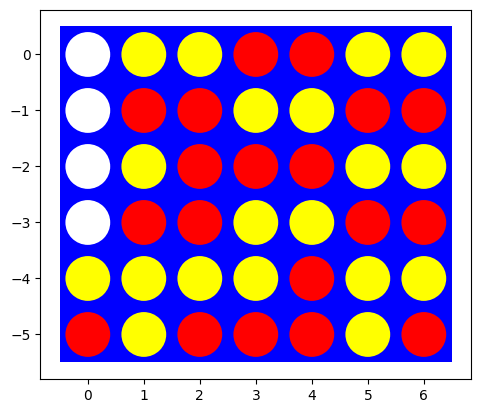

In [ ]:

result,final_board,all_boards = truly_dynamic_environment(players, size=(6,7), visual = True)
# T - 6, C - 4
visualize(final_board)

Slow a replay for analysis.

In [ ]:
replay(all_boards)